<a href="https://colab.research.google.com/github/Oaybarf/FX/blob/main/Github_FX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correr Código

In [1]:
import pandas as pd
from datetime import datetime
import pytz

# Definir la zona horaria de Perú
timezone = pytz.timezone("America/Lima")

# Obtener la fecha y hora actual en Perú
current_time_peru = datetime.now(timezone)

current_time_peru = current_time_peru.strftime("%Y-%m-%d %H:%M:%S")

now = datetime.now()
current_time = now.strftime("%Y-%m-%d %H:%M:%S")

print(current_time_peru)

2024-10-10 16:31:48


In [2]:
%%capture
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
import matplotlib.dates as mdates
import numpy as np
from talib import MA_Type
from matplotlib.offsetbox import AnchoredText


stock_symbol = 'PEN=X' # USD
# stock_symbol = 'VSAT' # VIASAT

stock_data = yf.download(stock_symbol,  period="max")

# Create a Date column
stock_data['Date'] = stock_data.index

# Drop the Date as index
stock_data.reset_index(drop=True, inplace=True)

dt_all = pd.date_range(start=stock_data.index[0],end=stock_data.index[-1])

dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data.index)]

dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

# 1. EMA 10, 20, 50
# --------------------------------------------
stock_data['EMA10'] = stock_data['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
stock_data['EMA20'] = stock_data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
stock_data['EMA50'] = stock_data['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
stock_data['EMA100'] = stock_data['Close'].ewm(span=100, min_periods=100, adjust=False).mean()
stock_data['EMA200'] = stock_data['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

# 2. MACD values
# --------------------------------------------
stock_data['macd'], stock_data['macdSignal'], stock_data['macdHist'] = ta.MACD(stock_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['macddiff1'] = stock_data['macd'].shift(1) - stock_data['macdSignal'].shift(1)
stock_data['macddiff-1'] = stock_data['macd'].shift(-1) - stock_data['macdSignal'].shift(-1)

# 3. RSI
# --------------------------------------------
stock_data['RSI'] = ta.RSI(stock_data.Close, 14)


# 4. Bollinger Bands
# --------------------------------------------
stock_data['BU'], stock_data['BM'], stock_data['BL'] = ta.BBANDS(stock_data.Close,
                                                                 timeperiod=20,
                                                                 matype=MA_Type.EMA)
# 5. Buy and Sell Signals
# --------------------------------------------
# Drop Buy and Sell columns if they exist
stock_data.drop(['Buy', 'Sell'], inplace=True, axis=1, errors='ignore')

# Create DataFrame
df_buy = stock_data.query('Low < BL')[['Date', 'Close']]
df_sell = stock_data.query('High > BU')[['Date', 'Close']]

# 5. ATR
# --------------------------------------------
stock_data['ATR'] = ta.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['ATR_SMA_1year'] = stock_data['ATR'].rolling(window=252).mean()

# Filtrar datos para los últimos 6 meses
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=2)
stock_data = stock_data[stock_data['Date'] >= six_months_ago]

[*********************100%***********************]  1 of 1 completed

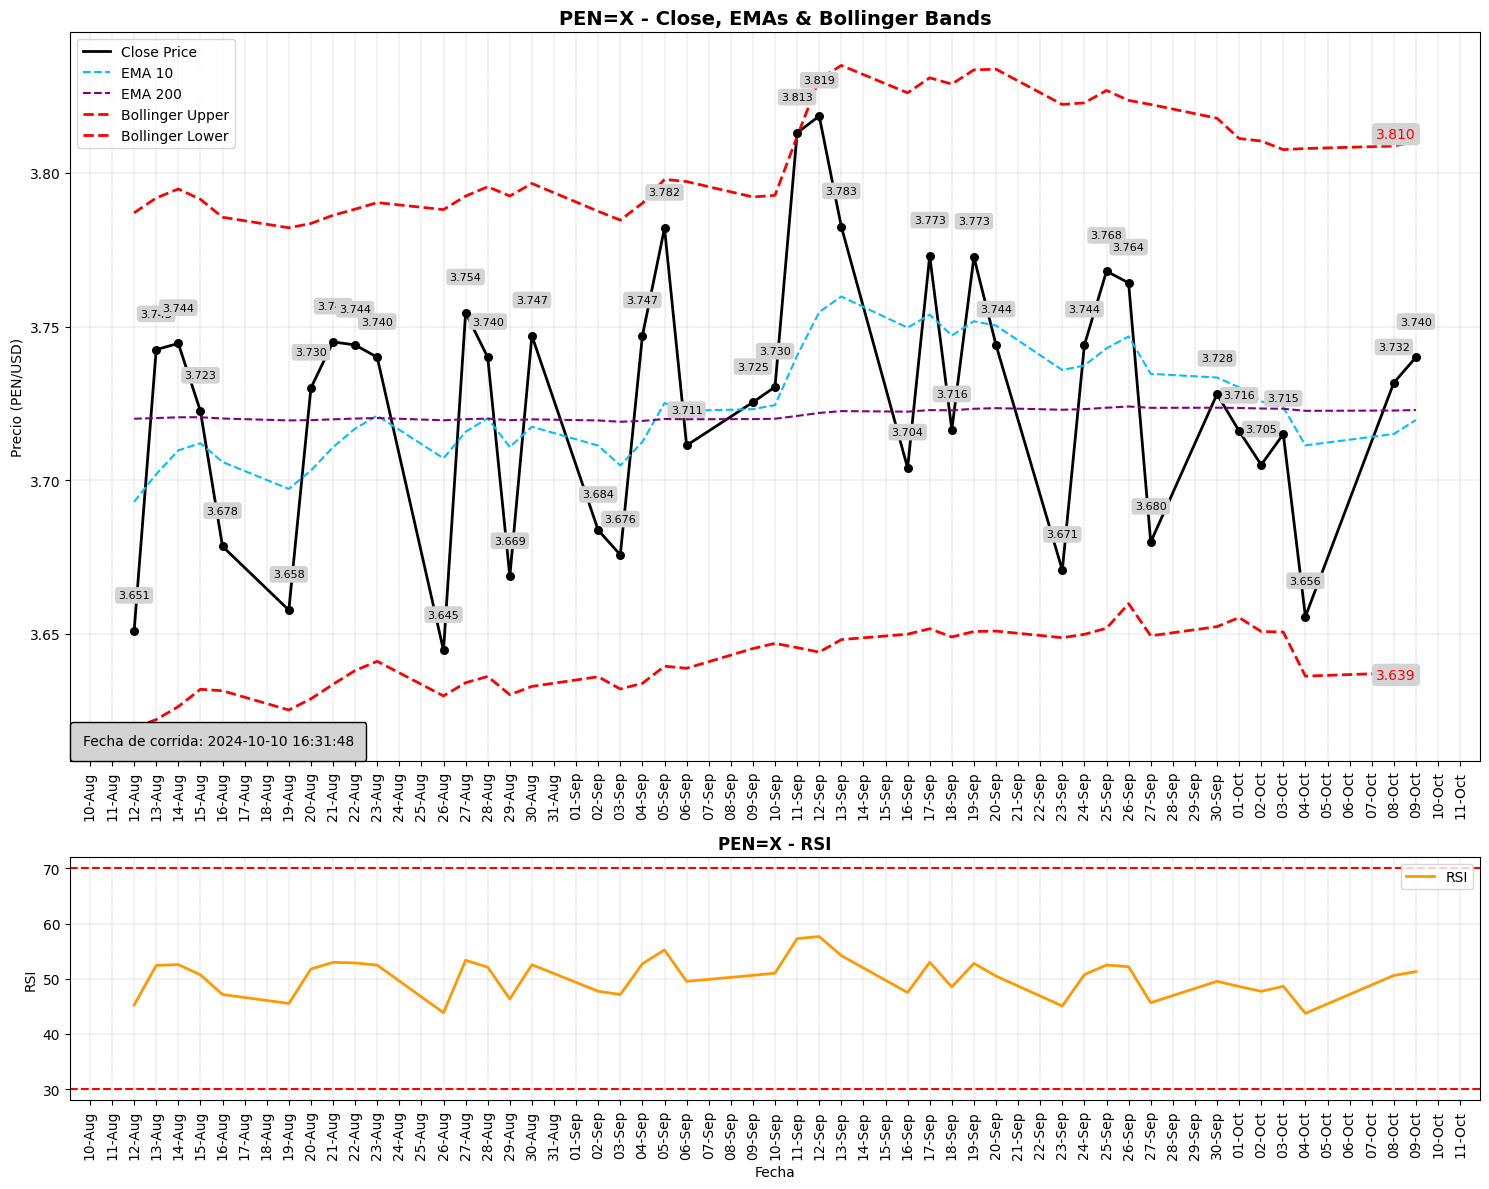

In [4]:
# Crear la figura con dos subplots (uno para precio y EMAs, otro para RSI)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [3, 1]})

# Gráfico 1: Precio de cierre, EMAs y Bollinger Bands
ax1.plot(stock_data['Date'], stock_data['Close'], color='black', label='Close Price', linewidth=2, linestyle='-')
ax1.plot(stock_data['Date'], stock_data['EMA10'], color='#00BFFF', label='EMA 10', linewidth=1.5, linestyle='--')
ax1.plot(stock_data['Date'], stock_data['EMA200'], color='purple', label='EMA 200', linewidth=1.5, linestyle='--')

# Bollinger Bands
ax1.plot(stock_data['Date'], stock_data['BU'], color='red', label='Bollinger Upper', linestyle='--', linewidth=2)
ax1.plot(stock_data['Date'], stock_data['BL'], color='red', label='Bollinger Lower', linestyle='--', linewidth=2)

# Agregar puntos para el precio de cierre
ax1.scatter(stock_data['Date'], stock_data['Close'], color='black', s=30, zorder=5)

# Añadir etiquetas con fondo gris para el precio de cierre
for index, row in stock_data.iterrows():
   ax1.text(row['Date'], row['Close'] + 0.01, f"{row['Close']:.3f}",
            fontsize=8, ha='center', color='black', verticalalignment='bottom',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))


last_row = stock_data.iloc[-1]  # Última fila de datos
ax1.text(last_row['Date'], last_row['BU'], f"{last_row['BU']:.3f}",
         fontsize=10, ha='right', color='red', verticalalignment='bottom',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))

ax1.text(last_row['Date'], last_row['BL'], f"{last_row['BL']:.3f}",
         fontsize=10, ha='right', color='red', verticalalignment='top',
         bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3'))



# Títulos y etiquetas
ax1.set_title(f"{stock_symbol} - Close, EMAs & Bollinger Bands", fontsize=14, fontweight='bold')
ax1.set_ylabel('Precio (PEN/USD)', fontsize=10)
ax1.legend()
ax1.grid(color='gray', linestyle='--', linewidth=0.2)

# Ajustar el formato de fecha
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Rotar etiquetas de fecha
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Gráfico 2: RSI
ax2.plot(stock_data['Date'], stock_data['RSI'], color='#FE9900', label='RSI', linewidth=2)
ax2.axhline(y=70, color='red', linestyle='--')  # Línea de sobrecompra
ax2.axhline(y=30, color='red', linestyle='--')  # Línea de sobreventa

# Títulos y etiquetas
ax2.set_title(f"{stock_symbol} - RSI", fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=10)
ax2.set_ylabel('RSI', fontsize=10)
ax2.legend()
ax2.grid(color='gray', linestyle='--', linewidth=0.2)

# Ajustar el formato de fecha
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

# Rotar etiquetas de fecha
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)


# Crear un cuadro de texto con la fecha y hora de corrida
text_box = AnchoredText(f"Fecha de corrida: {current_time_peru}", loc='lower left', prop=dict(size=10), frameon=True)
text_box.patch.set_boxstyle("round,pad=0.5,rounding_size=0.2")
text_box.patch.set_facecolor("lightgrey")
text_box.patch.set_edgecolor("black")

# Añadir el cuadro al gráfico (en el subplot superior)
ax1.add_artist(text_box)

# Ajustar diseño y mostrar gráfico
plt.tight_layout()

# Guardar el gráfico como archivo PNG
plt.savefig('historical_close_price.png')  # Guardar en el directorio actual

# Mostrar el gráfico
plt.show()